## AML 2304 – Natural Language Processing

Instructor: havik Gandhi

Members:

* Anmolpreet Kaur (C0895954)
* Antonio Carlos De Mello Mendes (C0866063)
* Ann Margaret Silva (C0903604)
* Eduardo Jr Morales (C0900536)
* Flora Mae Villarin (C0905584)
* Maria Jessa Cruz (C0910329)
* Prescila Mora (C0896891)

Datasets:
* Bakhet, M. (2022). Amazon Book Reviews. Kaggle. Retrieved from https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews?fbclid=IwZXh0bgNhZW0CMTAAAR1CeZc5I7CIAawbB9Bq_sephstdZ04MStFp0Nr1PT7vHtkIoy-wiZ33fcs_aem_ZmFrZWR1bW15MTZieXRlcw

### **Amazon Book Recommendation with Emotion Analysis**

In [2]:
# Loading libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import torch
import pickle
from sklearn.preprocessing import OneHotEncoder

import os
import enchant

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Check if the environment variable is set
filename = os.getenv('SAMPLE_DATA_FILENAME')
print('filename:', filename)
if filename:
    # If the filename environment variable is set, load the dataset from it
    try:
        base_dir = "../data"
        data_abr = pd.read_csv(f"{base_dir}/{filename}")        
        print(f"Loaded data from {filename}")
    except FileNotFoundError:
        print(f"File {filename} not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    # If the environment variable is not set, use existing code
    base_dir = "../data"

    # Load datasets from default paths
    try:
        data_titl = pd.read_csv(f"{base_dir}/books_data.csv")
        data_rate = pd.read_csv(f"{base_dir}/Books_rating.csv")
        
        # Merge datasets
        data_abr = pd.merge(data_titl, data_rate, how="outer", on="Title", validate="one_to_many")
        
        # Display the first 5 entries of the DataFrame
        print(data_abr.head())
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

filename: sample_dataset_2_20240807_023224.csv
Loaded data from sample_dataset_2_20240807_023224.csv


In [3]:
'''
# Load datasets
base_dir = "/content/drive/MyDrive/Colab Notebooks/AmazonBookRecommendation"

# Features of books
data_titl = pd.read_csv(f'{base_dir}/books_data.csv')

# Features of rating
data_rate = pd.read_csv(f"{base_dir}/Books_rating.csv")

# Merge datasets
data_abr = pd.merge(data_titl, data_rate, how="outer", on="Title", validate="one_to_many")

# Display the first 5 entries of the DataFrame
data_abr.head()
'''

'\n# Load datasets\nbase_dir = "/content/drive/MyDrive/Colab Notebooks/AmazonBookRecommendation"\n\n# Features of books\ndata_titl = pd.read_csv(f\'{base_dir}/books_data.csv\')\n\n# Features of rating\ndata_rate = pd.read_csv(f"{base_dir}/Books_rating.csv")\n\n# Merge datasets\ndata_abr = pd.merge(data_titl, data_rate, how="outer", on="Title", validate="one_to_many")\n\n# Display the first 5 entries of the DataFrame\ndata_abr.head()\n'

#### **A. Data Cleaning:**

Inspecting more relevant Amazon book recommendations and sentiment analysis information will promote an exploration of aspects that influence how good or bad books and their authors are, based on user review contents and ratings.

The Amazon Book Recommendation Data Description includes an identifier for each book/user, ratings of reviews and books, and texts of reviews.

In [6]:
data_abr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               2 non-null      object 
 1   description         2 non-null      object 
 2   authors             2 non-null      object 
 3   image               2 non-null      object 
 4   previewLink         2 non-null      object 
 5   publisher           2 non-null      object 
 6   publishedDate       2 non-null      object 
 7   infoLink            2 non-null      object 
 8   categories          2 non-null      object 
 9   ratingsCount        2 non-null      float64
 10  Id                  2 non-null      object 
 11  Price               0 non-null      float64
 12  User_id             2 non-null      object 
 13  profileName         2 non-null      object 
 14  review/helpfulness  2 non-null      object 
 15  review/score        2 non-null      float64
 16  review/time 

In [7]:
# Rename the reviews columns
data_abr.rename(columns={'review/text': 'review_text', 'review/helpfulness': 'review_helpfulness', 'review/score': 'review_score'}, inplace=True)

In [8]:
# Check the null values for relevant columns
data_abr[['Id', 'Title', 'categories', 'User_id', 'review_helpfulness', 'review_score', 'review_text']].isnull().sum()

Id                    0
Title                 0
categories            0
User_id               0
review_helpfulness    0
review_score          0
review_text           0
dtype: int64

In [9]:
# Filling columns missing values with a placeholder like "Unknown"
data_abr['categories'].fillna(('Unknown'), inplace = True)
data_abr['User_id'].fillna(('Unknown'), inplace = True)

# Dropping rows with missing values
data_abr.dropna(subset=['Title', 'review_text'], inplace=True)

In [10]:
# Check the null values again for relevant columns
data_abr[['Title', 'categories', 'User_id', 'review_helpfulness', 'review_score', 'review_text']].isnull().sum()

Title                 0
categories            0
User_id               0
review_helpfulness    0
review_score          0
review_text           0
dtype: int64

In [11]:
# Select relevant column for use in the dataframe
data_abr_relevant = data_abr[['Id', 'categories', 'User_id', 'review_helpfulness', 'review_score', 'review_text']]

In [12]:
# Check for duplicated reviews
data_abr_relevant.describe(include='all')

,Id,categories,User_id,review_helpfulness,review_score,review_text
count,2,2,2,2,2.000000,2
unique,2,2,2,2,NaN,2
top,B000J521DU,['Dragons'],A3T41SD51GPEXF,0/1,NaN,I bought this book for my 13 year old son. He ...
freq,1,1,1,1,NaN,1
mean,NaN,NaN,NaN,NaN,4.500000,NaN
std,NaN,NaN,NaN,NaN,0.707107,NaN
min,NaN,NaN,NaN,NaN,4.000000,NaN
25%,NaN,NaN,NaN,NaN,4.250000,NaN
50%,NaN,NaN,NaN,NaN,4.500000,NaN
75%,NaN,NaN,NaN,NaN,4.750000,NaN


The Id column contains 2,999,784 rows with 221,989 unique values. In contrast, the review_text column also has 2,999,784 rows, with 2,062,627 unique entries. This means there are 937,157 duplicate entries in the review_text column.

In [13]:
# Check for duplicate entries
data_abr_relevant.review_text.duplicated(keep = "first").value_counts()

review_text
False    2
Name: count, dtype: int64

In [14]:
# Drop duplicate entries
data_abr_relevant.drop_duplicates(subset = "review_text", keep = "first", inplace=True, ignore_index=True)
data_abr_relevant.review_text.describe()

C:\Users\admin\AppData\Local\Temp\ipykernel_26192\4163860825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant.drop_duplicates(subset = "review_text", keep = "first", inplace=True, ignore_index=True)


count                                                     2
unique                                                    2
top       I bought this book for my 13 year old son. He ...
freq                                                      1
Name: review_text, dtype: object

##### Text Processing

The following functions convert text into a representations that is better suited for processing and analysis in NLP, using text cleaning for removing stop words, punctuation, and other non-essential elements.

Also, tokenization divides strings containing multiple words into smaller parts. Then, eliminate common words from a piece of text using stop words, and use stemming to normalize words by reducing them to their base form.

In [15]:
# Data Preprocessing Functions
nltk.download('wordnet')

# Function to text cleaning
stop_words = set(stopwords.words('english'))

# Define function to handle emojis using regex
def handle_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Define function to handle slang
def handle_slang(text):
    slang_dict = {
        "brb": "be right back",
        "lol": "laughing out loud",
        "smh": "shaking my head",
        "omg": "oh my god",
        "idk": "I don't know",
        "imo": "in my opinion",
        "tbh": "to be honest",
        'btw': 'by the way',
        'ttyl': 'talk to you later',
        'u': 'you',
        'ur': 'you are',
        'lmk': 'let me know',
        'smh': 'shaking my head',
        'tbh': 'to be honest',
        'rofl': 'rolling on the floor laughing',
        'wtf': 'what the f***',
        'bff': 'best friends forever',
        'fyi': 'for your information',
        'jk': 'just kidding',
        'np': 'no problem',
        'omw': 'on my way',
        'rn': 'right now',
        'thx': 'thanks',
        'afaik': 'as far as I know',
        'b4': 'before',
        'cya': 'see you',
        'gr8': 'great',
        'msg': 'message',
        'nvm': 'never mind',
        'plz': 'please',
        'sry': 'sorry',
        'w/': 'with',
        'w/o': 'without',
        'yolo': 'you only live once',
        'wya': 'where you at',
        'fomo': 'fear of missing out',
        'ikr': 'I know, right?',
        'imho': 'in my humble opinion',
        'irl': 'in real life',
        'lit': 'exciting or excellent',
        'hmu': 'hit me up',
        'bae': 'before anyone else',
        'n': 'and',
        'r': 'are',
        'b': 'with',
        'z': 'the',
        'th': 'the',
        'int': 'international',
        'tha': 'that',
        'ppl': 'people',
        'cdn': 'canadians',
        'jan': 'january'
    }
    for slang, replacement in slang_dict.items():
        text = re.sub(r'\b' + re.escape(slang) + r'\b', replacement, text, flags=re.IGNORECASE)
    return text

# Define function to handle abbreviations
def handle_abbreviations(text):
    abbreviation_dict = {
        "ASAP": "as soon as possible",
        "FYI": "for your information",
        "BTW": "by the way",
        "IDK": "I don't know",
        "OMG": "oh my god",
        "BRB": "be right back",
        "LOL": "laughing out loud",
        "TBH": "to be honest"
    }
    for abbreviation, replacement in abbreviation_dict.items():
        text = re.sub(r'\b' + re.escape(abbreviation) + r'\b', replacement, text, flags=re.IGNORECASE)
    return text

def convert_hashtags_to_words(tweet):
    # Find all hashtags
    hashtags = re.findall(r'#\w+', tweet)
    for hashtag in hashtags:
        # Replace hashtags with the words, removing the '#'
        tweet = tweet.replace(hashtag, ' '.join(re.findall(r'[A-Z][^A-Z]*', hashtag[1:])))
    return tweet
# Define function for stemming and lemmatization
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Define function to remove stop words
def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Data cleaning function with all the processing steps
def clean_text(text):
    if not isinstance(text, str):
        return ""  # Return an empty string if the input is not a string
    text = re.sub(r'http\S+', '', text)       # Remove URLs
    text = re.sub(r'&[a-z]+;', '', text)      # Remove &***;
    text = convert_hashtags_to_words(text)    # Remove hashtags
    text = re.sub(r'\@\w+|\#','', text)       # Remove mentions and hashtags
    text = re.sub(r'<.*?>', '', text)         # Remove HTML tags
    text = re.sub(r'@\w+', '', text)          # Remove mentions 
    text = handle_slang(text)                 # Replace slang words
    text = handle_emojis(text)                # Remove emojis    
    text = re.sub(r'[^\w\s]', '', text)       # Remove punctuation
    text = handle_abbreviations(text)         # Replace abbreviations    
    text = lemmatize(text)                    # Perform stemming and lemmatization
    text = re.sub(r'[^A-Za-z\s]', '', text)   # Remove punctuation  
    text = re.sub(r'[,\'"!-:)]', '', text)    # Remove special characters
    text = remove_stopwords(text)             # Remove stop words
    text = text.lower()                       # Convert to lowercase     
    text = ' '.join(text.split())             # Remove extra spaces
    return text

# Function to tokenize the words, remove stop words, and treat normalization
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Normalize words by using Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# Convert all text reviews to strings
data_abr_relevant['review_text'] = data_abr_relevant['review_text'].astype(str)

# Apply cleaning to the 'processed_text' column
data_abr_relevant['processed_text'] = data_abr_relevant['review_text'].apply(clean_text)

# Remove rows where processed_text is empty after cleaning
data_abr_relevant = data_abr_relevant[data_abr_relevant['processed_text'].str.strip().astype(bool)]

C:\Users\admin\AppData\Local\Temp\ipykernel_26192\2645685360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant['review_text'] = data_abr_relevant['review_text'].astype(str)
C:\Users\admin\AppData\Local\Temp\ipykernel_26192\2645685360.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant['processed_text'] = data_abr_relevant['review_text'].apply(clean_text)


In [18]:
# Contractions dictionary
contractions_dict = {
    "ain't": "is not",
    "aint": "is not",
    "aren't": "are not",
    "arent": "are not",
    "can't": "cannot",
    "cant": "cannot",
    "can't've": "cannot have",
    "cantve": "cannot have",
    "could've": "could have",
    "couldve": "could have",
    "couldn't": "could not",
    "couldnt": "could not",
    "didn't": "did not",
    "didnt": "did not",
    "doesn't": "does not",
    "doesnt": "does not",
    "don't": "do not",
    "dont": "do not",
    "hadn't": "had not",
    "hadnt": "had not",
    "hasn't": "has not",
    "hasnt": "has not",
    "haven't": "have not",
    "havent": "have not",
    "he'd": "he would",
    "hed": "he would",
    "he'll": "he will",
    "hell": "he will",
    "he's": "he is",
    "hes": "he is",
    "how'd": "how did",
    "howd": "how did",
    "how'll": "how will",
    "howll": "how will",
    "how's": "how is",
    "hows": "how is",
    "i'd": "i would",
    "id": "i would",
    "i'll": "i will",
    "ill": "i will",
    "i'm": "i am",
    "im": "i am",
    "i've": "i have",
    "ive": "i have",
    "isn't": "is not",
    "isnt": "is not",
    "it'd": "it would",
    "itd": "it would",
    "it'll": "it will",
    "itll": "it will",
    "it's": "it is",
    "its": "it is",
    "let's": "let us",
    "lets": "let us",
    "ma'am": "madam",
    "maam": "madam",
    "mayn't": "may not",
    "maynt": "may not",
    "might've": "might have",
    "mightve": "might have",
    "mightn't": "might not",
    "mightnt": "might not",
    "must've": "must have",
    "mustve": "must have",
    "mustn't": "must not",
    "mustnt": "must not",
    "needn't": "need not",
    "neednt": "need not",
    "oughtn't": "ought not",
    "oughtnt": "ought not",
    "shan't": "shall not",
    "shant": "shall not",
    "she'd": "she would",
    "shed": "she would",
    "she'll": "she will",
    "shell": "she will",
    "she's": "she is",
    "shes": "she is",
    "should've": "should have",
    "shouldve": "should have",
    "shouldn't": "should not",
    "shouldnt": "should not",
    "that's": "that is",
    "thats": "that is",
    "there's": "there is",
    "theres": "there is",
    "they'd": "they would",
    "theyd": "they would",
    "they'll": "they will",
    "theyll": "they will",
    "they're": "they are",
    "theyre": "they are",
    "they've": "they have",
    "theyve": "they have",
    "wasn't": "was not",
    "wasnt": "was not",
    "we'd": "we would",
    "wed": "we would",
    "we'll": "we will",
    "well": "we will",
    "we're": "we are",
    "were": "we are",
    "we've": "we have",
    "weve": "we have",
    "weren't": "were not",
    "werent": "were not",
    "what'll": "what will",
    "whatll": "what will",
    "what're": "what are",
    "whatre": "what are",
    "what's": "what is",
    "whats": "what is",
    "what've": "what have",
    "whatve": "what have",
    "where's": "where is",
    "wheres": "where is",
    "who'd": "who would",
    "whod": "who would",
    "who'll": "who will",
    "wholl": "who will",
    "who're": "who are",
    "whore": "who are",
    "who's": "who is",
    "whos": "who is",
    "who've": "who have",
    "whove": "who have",
    "won't": "will not",
    "wont": "will not",
    "wouldn't": "would not",
    "wouldnt": "would not",
    "you'd": "you would",
    "youd": "you would",
    "you'll": "you will",
    "youll": "you will",
    "you're": "you are",
    "youre": "you are",
    "you've": "you have",
    "youve": "you have"
}

# Function to expand contractions in a given text using the contractions dictionary
def expand_contractions(text, contractions_dict):
    # Regular expression pattern to find contractions in text
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')

    # Function to expand a matched contraction using the dictionary
    def expand_match(contraction):
        match = contraction.group(0)
        expanded = contractions_dict.get(match)
        if not expanded:
            expanded = contractions_dict.get(match.lower())
        return expanded

    # Apply the contraction expansion function to the text
    expanded_text = pattern.sub(expand_match, text)
    return expanded_text

# Apply contraction expansion to all cells of the DataFrame
data_abr_relevant['processed_text'] = data_abr_relevant['processed_text'].apply(lambda x: expand_contractions(x, contractions_dict))

##### Text Normalization

In [19]:
# Tokenize the text into separate words

# Convert all the text reviews to strings
data_abr_relevant['processed_text'] = data_abr_relevant['processed_text'].astype(str)

# Apply preprocessing to the 'processed_text' column
data_abr_relevant["tokens"] = data_abr_relevant["processed_text"].apply(preprocess_text)
data_abr_relevant.drop(columns=['review_text'], axis = 1, inplace=True)

data_abr_relevant.head()

,Id,categories,User_id,review_helpfulness,review_score,tokens
0,B000J521DU,['Dragons'],A3T41SD51GPEXF,0/1,4.0,"[bought, book, year, old, son, devoured, tolki..."
1,B000HGVHKO,['Juvenile Fiction'],A2L8FOBZY6GMWU,0/0,5.0,"[wonderful, wizard, oz, forever, timeless, sto..."


In [20]:
pip install pyenchant

Note: you may need to restart the kernel to use updated packages.


In [21]:
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the English dictionary using pyenchant
english_dict = enchant.Dict("en_US")

def suggest_corrections(word):
    # Check if the word exists in the dictionary
    if english_dict.check(word):
        return [word]  # The word is already correct
    
    # Stem the word
    stemmed_word = lemmatizer.lemmatize(word)

    # Get suggestions based on stemmed word
    suggestions = [suggestion.lower() for suggestion in english_dict.suggest(stemmed_word)]
    
    # Filter suggestions to include only those starting with the same letter as the original word
    first_letter = word[0]
    valid_suggestions = [
        suggestion for suggestion in suggestions
        if suggestion.startswith(first_letter)
    ]
  
    # If no valid suggestions are found, check if any suggestions are substrings of the original word
    if not valid_suggestions:
        valid_suggestions = [
            suggestion for suggestion in suggestions
            if suggestion in word
        ]
    if not valid_suggestions and suggestions and len(suggestions[0]) > 1:
        return [suggestions[0]]

    # If only one valid suggestion is found and it's a single character, return the original word
    if len(valid_suggestions) == 1 and len(valid_suggestions[0]) == 1:
        return [word]
    
    # Return original word if no valid suggestions are found
    if not valid_suggestions:
        return [word]
    
    # Return only the first valid suggestion
    if valid_suggestions:
        return [valid_suggestions[0]]
    
    return [word]

def process_word_list(word_list):
    all_tokens = []
    
    for word in word_list:
        suggestions = suggest_corrections(word)
        
        # Skip single-character suggestions
        if len(suggestions[0]) == 1:
            continue
        
        all_tokens.extend(suggestions)
    
    return all_tokens

# Apply the function process_word_list
data_abr_relevant['tokens'] = data_abr_relevant['tokens'].apply(process_word_list)
data_abr_relevant['processed_text'] = data_abr_relevant['tokens'].apply(lambda tokens: ' '.join(tokens))


##### **Analyzing the distribuition of the words within the dataset**

Analyze the vocabulary and its distribution to use in feature selection, understand document content, or prepare data for modeling, and visualize the results through plotting.

In [22]:
# Get a list of all words in the tokenized texts
all_words = [word for tokens in data_abr_relevant["tokens"] for word in tokens]

# Get a list of text lengths in the tokenized texts
text_lengths = [len(tokens) for tokens in data_abr_relevant["tokens"]]

# List all unique words in the dataset and sort them for future convenience
vocab = sorted(set(all_words))

# Print the total number of words and the vocabulary size
print(f'Total number of words: {len(all_words)}')
print(f'Vocabulary size: {len(vocab)}')

# Print the maximum sentence length
print(f'Max text length: {max(text_lengths)}')

Total number of words: 52
Vocabulary size: 48
Max text length: 39


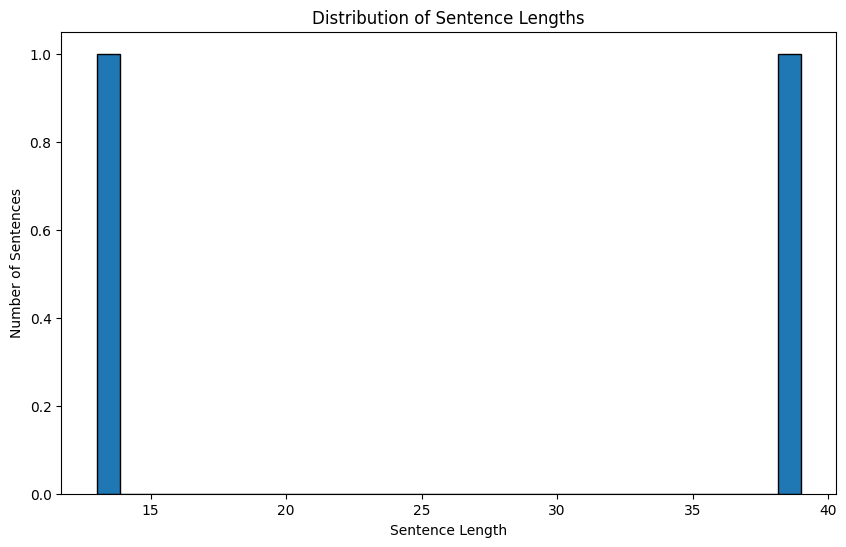

In [23]:
import matplotlib.pyplot as plt

# Define the figure size and create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the labels for the x and y axes
ax.set_xlabel('Sentence Length')
ax.set_ylabel('Number of Sentences')

# Plot the histogram of sentence lengths
ax.hist(text_lengths, bins=30, edgecolor='black')

# Set the title for the plot
ax.set_title('Distribution of Sentence Lengths')

# Show the plot
plt.show()

In [24]:
data_abr_relevant.head()

,Id,categories,User_id,review_helpfulness,review_score,tokens
0,B000J521DU,['Dragons'],A3T41SD51GPEXF,0/1,4.0,"[bought, book, year, old, son, devoured, tolki..."
1,B000HGVHKO,['Juvenile Fiction'],A2L8FOBZY6GMWU,0/0,5.0,"[wonderful, wizard, oz, forever, timeless, sto..."


In [25]:
# Save data cleaning file to local
data_abr_relevant.to_csv(f"{base_dir}/data_cleaned.csv")

In [26]:
# Rename the reviews columns
data_abr.rename(columns={'User_id': 'user_id', 'publishedDate': 'published_date', 'review/text': 'review_text', 'review/helpfulness': 'review_helpfulness', 'review/score': 'review_score'}, inplace=True)

# Dropping rows with missing values
data_abr.dropna(subset=['Title', 'categories', 'review_text', 'published_date', 'user_id'], inplace=True)

# Select relevant column for use in the dataframe
data_abr_relevant = data_abr[['Id', 'categories', 'user_id', 'published_date', 'review_helpfulness', 'review_score', 'review_text']]

# Split review/helpfulness column into helpful and Total
data_abr_relevant[['useful', 'total_of_person']] = data_abr_relevant['review_helpfulness'].str.split('/', expand=True)

# Select relevant columns for use in the dataframe
data_abr_relevant = data_abr_relevant[['Id','categories', 'published_date', 'user_id', 'useful', 'total_of_person', 'review_score', 'review_text']]

# Save raw review text file to local adding user_id
data_books_with_raw_review = data_abr_relevant[['Id','categories', 'published_date', 'user_id', 'useful', 'total_of_person', 'review_score', 'review_text']]
data_books_with_raw_review.to_csv(f"{base_dir}/books_with_raw_review.csv")

C:\Users\admin\AppData\Local\Temp\ipykernel_26192\1370949214.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant[['useful', 'total_of_person']] = data_abr_relevant['review_helpfulness'].str.split('/', expand=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_26192\1370949214.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant[['useful', 'total_of_person']] = data_abr_relevant['review_helpfulness'].str.split('/', expand=True)
